In [2]:
 #!pip install catboost
 #!pip install pycaret
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import datetime as dt
from pycaret.regression import *
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')

     |████████████████████████████████| 69.2 MB 4.7 kB/s 
     |████████████████████████████████| 264 kB 4.8 MB/s 
     |████████████████████████████████| 271 kB 10.0 MB/s 
     |████████████████████████████████| 6.8 MB 9.9 MB/s 
     |████████████████████████████████| 1.7 MB 64.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 80 kB 8.1 MB/s 
     |████████████████████████████████| 248 kB 50.8 MB/s 
     |████████████████████████████████| 2.0 MB 57.3 MB/s 
     |████████████████████████████████| 14.4 MB 64 kB/s 
     |████████████████████████████████| 1.3 MB 37.0 MB/s 
     |████████████████████████████████| 167 kB 61.8 MB/s 
     |████████████████████████████████| 56 kB 4.1 MB/s 
     |████████████████████████████████| 105 kB 50.8 MB/s 
     |████████████████████████████████| 10.1 MB 32.7 MB/s 
     |███████████████████

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("font", family = "Malgun Gothic")
plt.rc("axes", unicode_minus = False)
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

# 데이터 로드 및 피쳐 생성

In [5]:
train = pd.read_csv('/gdrive/MyDrive/train.csv')
test = pd.read_csv('/gdrive/MyDrive/test.csv')

# 새로운 변수 생성
# 코드공유게시판에서 현재는 사라진 게시글을 참고하여 변수를 생성하였음.
train[['현본사소속재택근무자수', '중식계', '석식계']] = train[['현본사소속재택근무자수', '중식계', '석식계']].astype('int')
test['현본사소속재택근무자수'] = test['현본사소속재택근무자수'].astype('int')

train['일자'] = pd.to_datetime(train['일자'])
test['일자'] = pd.to_datetime(test['일자'])

train['년'] = train['일자'].dt.year
train['월'] = train['일자'].dt.month
train['일'] = train['일자'].dt.day
train['주'] = train['일자'].dt.week
train['요일'] = train['일자'].dt.weekday
train['출근'] = train['본사정원수']-(train['본사휴가자수']+train['본사출장자수']+train['현본사소속재택근무자수'])
train['휴가비율'] = train['본사휴가자수']/train['본사정원수']
train['출장비율'] = train['본사출장자수']/train['본사정원수']
train['야근비율'] = train['본사시간외근무명령서승인건수']/train['출근']
train['재택비율'] = train['현본사소속재택근무자수']/train['본사정원수']

test['년'] = test['일자'].dt.year
test['월'] = test['일자'].dt.month
test['일'] = test['일자'].dt.day
test['주'] = test['일자'].dt.week
test['요일'] = test['일자'].dt.weekday
test['출근'] = test['본사정원수']-(test['본사휴가자수']+test['본사출장자수']+test['현본사소속재택근무자수'])
test['휴가비율'] = test['본사휴가자수']/test['본사정원수']
test['출장비율'] = test['본사출장자수']/test['본사정원수']
test['야근비율'] = test['본사시간외근무명령서승인건수']/test['출근']
test['재택비율'] = test['현본사소속재택근무자수']/test['본사정원수']

train['식사가능자수'] = train['본사정원수'] - train['본사휴가자수'] - train['현본사소속재택근무자수']
test['식사가능자수'] = test['본사정원수'] - test['본사휴가자수'] - test['현본사소속재택근무자수']

In [6]:
train.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,년,월,일,주,출근,휴가비율,출장비율,야근비율,재택비율,식사가능자수
0,2016-02-01,0,2601,50,150,238,0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039,331,2016,2,1,5,2401,0.019223,0.057670,0.099125,0.0,2551
1,2016-02-02,1,2601,50,173,319,0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867,560,2016,2,2,5,2378,0.019223,0.066513,0.134146,0.0,2551
2,2016-02-03,2,2601,56,180,111,0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017,573,2016,2,3,5,2365,0.021530,0.069204,0.046934,0.0,2545
3,2016-02-04,3,2601,104,220,355,0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978,525,2016,2,4,5,2277,0.039985,0.084583,0.155907,0.0,2497
4,2016-02-05,4,2601,278,181,34,0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925,330,2016,2,5,5,2142,0.106882,0.069589,0.015873,0.0,2323


# 모델링
중식 모델링

In [10]:
# 자기 계발의 날(매달 마지막 주 수요일), 공휴일 전, 후에 대한 데이터 생성 후 병합
# 공휴일 합은 공휴일 전이자 공휴일 후에 해당하는 경우를 의미
# 주요 메뉴를 선정하여 주요 메뉴 개수를 만들어 보았으나 메뉴에 대한 의미가 크지 않다고 생각하여 나중에는 사용하지 않았음
# 선호 역시 주요 메뉴의 개수가 3개 이상인지 아닌지를 의미함.
date = pd.read_csv('date1.csv')
date.head()

,일자,공휴일전,공휴일후,공휴일합,개수,선호,계발
0,2016-02-01,0,0,0,4.0,1.0,0
1,2016-02-02,0,0,0,4.0,1.0,0
2,2016-02-03,0,0,0,4.0,1.0,0
3,2016-02-04,0,0,0,3.0,1.0,0
4,2016-02-05,1,0,1,4.0,1.0,0


In [11]:
date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일자      1255 non-null   object 
 1   공휴일전    1255 non-null   int64  
 2   공휴일후    1255 non-null   int64  
 3   공휴일합    1255 non-null   int64  
 4   개수      1205 non-null   float64
 5   선호      1205 non-null   float64
 6   계발      1255 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 68.8+ KB


In [12]:
date['일자'] = pd.to_datetime(date['일자'])

In [13]:
date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   일자      1255 non-null   datetime64[ns]
 1   공휴일전    1255 non-null   int64         
 2   공휴일후    1255 non-null   int64         
 3   공휴일합    1255 non-null   int64         
 4   개수      1205 non-null   float64       
 5   선호      1205 non-null   float64       
 6   계발      1255 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 68.8 KB


In [14]:
# 기존의 데이터프레임과 병합

train_mer1 = pd.merge(train, date, how = 'left', left_on='일자', right_on='일자')
train_mer1.head()

test_mer1 = pd.merge(test, date, how = 'left', left_on='일자', right_on='일자')
test_mer1.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,년,월,일,주,출근,휴가비율,출장비율,야근비율,재택비율,식사가능자수,공휴일전,공휴일후,공휴일합,개수,선호,계발
0,2021-01-27,2,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,2021,1,27,4,2355,0.029501,0.061012,0.002123,0.120013,2537,0,0,0,NaN,NaN,1
1,2021-01-28,3,2983,104,212,409,348,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,2021,1,28,4,2319,0.034864,0.071069,0.176369,0.116661,2531,0,0,0,NaN,NaN,0
2,2021-01-29,4,2983,270,249,0,294,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,2021,1,29,4,2170,0.090513,0.083473,0.000000,0.098558,2419,0,0,0,NaN,NaN,0
3,2021-02-01,0,2924,108,154,538,322,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,2021,2,1,5,2340,0.036936,0.052668,0.229915,0.110123,2494,0,0,0,NaN,NaN,0
4,2021-02-02,1,2924,62,186,455,314,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,2021,2,2,5,2362,0.021204,0.063611,0.192633,0.107387,2548,0,0,0,NaN,NaN,0


In [ ]:
# 외부데이터 - 코로나 사용
# 코로나 데이터는 공공데이터 포털에 있는 '보건복지부 코로나19 감염 현황＇ 을 사용함
# 아래 코드를 이용하여 불러왔으며, 불러온 데이터를 엑셀 파일로 저장하여 엑셀에서 수정하여 사용하였음.
# from datetime import datetime
# today = datetime.now().strftime('%Y%m%d') # datetime 라이브러리를 통해 현재 날짜 today 생성

# serviceKey = 'RY8GwXEX5npt3x%2F4E6PWiOZmTFyd4IZBbmw5NtJtE4Jt8sQ2JvGO849mBoLwVGnThJ%2BlMv9PWs3DsFKtkluvww%3D%3D' # 공공데이터포털에서 발급받은 서비스키
# params = {'ServiceKey':parse.unquote(serviceKey), # 서비스키(필수)
#           'startCreateDt':20200201,
#           'endCreateDt':today} # 데이터 생성일 종료범위(선택) - today(현재 날짜 입력)
# # 서비스URL
# url = 'http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19InfStateJson'

# res = requests.get(url, params=params)
# soup = bs(res.text, 'lxml')

# response = {'seq': '고유번호',
#             'statedt': '기준일',
#             'statetime': '기준시간',
#             'decidecnt': '확진자',
#             'clearcnt': '격리해제',
#             'examcnt': '검사진행',
#             'deathcnt': '사망자',
#             'carecnt': '치료중',
#             'resutlnegcnt': '음성',
#             'accexamcnt': '누적검사',
#             'accexamcompcnt': '누적검사완료',
#             'accdefrate': '누적확진률',
#             'createdt': '등록일시',
#             'updatedt': '수정'}

# items = soup.find_all('item')

# dic1 = dict(covid19=[])

# for item in items:
#     dic = {}
#     for x in item:
#         if x.name in set(response):
#             dic[x.name] = x.text
#     dic1['covid19'].append(dic)

# # xml을 dictionary로 바꿔 리스트 원소로 추가
# lst = []
# for y in items:
#     l = {}
#     for x in y:
#         l[x.name] = x.text
#     lst.append(l)
# lst

# df = pd.DataFrame(lst)
# df.columns = df.columns.map(response)
# df

In [20]:
covid = pd.read_csv('covid_정리_하영_로그1.csv', encoding='cp949')
# 새로운 칼럼 생성하였음.
# 전날대비확진자: 당일 기준 전날 대비 확진자 증감수
# 확진자증감: 당일 확진자-전날확진자
# 확진s: (당일확진자 – 그 전날 확진자)/전날 확진자*100 : 매출액증가율의 공식을 응용
# 전날대비확진자1 : 확진자가 누적임을 감안하여 시간이 지날수록 단위가 매우 커지고, 전염병이므로 증가하는 폭이 커짐을 반영하여 스케일 조정을 하기 위해 log변환을 시행


covid['기준날짜'] = pd.to_datetime(covid['기준날짜'])
covid['년'] = covid['기준날짜'].dt.year
covid['월'] = covid['기준날짜'].dt.month
covid['일'] = covid['기준날짜'].dt.day
covid['주'] = covid['기준날짜'].dt.week
covid['요일'] = covid['기준날짜'].dt.weekday
covid['전날대비확진자1'] = np.log(covid['전날대비확진자'])
covid = covid[['로그','누적확진률', '누적검사', '누적검사완료', '치료중', '격리해제', '사망자', '확진자', '기준날짜', '전날대비확진자1','전날대비확진자', '확진자증감','확진s']]
covid.head()

,로그,누적확진률,누적검사,누적검사완료,치료중,격리해제,사망자,확진자,기준날짜,전날대비확진자1,전날대비확진자,확진자증감,확진s
0,3.624488,5.557315,109591,75792,NaN,31,22,4212,2020-03-02,8.345693,4212,4212,100.000000
1,3.682326,5.329140,125851,90296,4159.0,34,28,4812,2020-03-03,6.396930,600,-3612,14.245014
2,3.726564,4.919986,136707,108293,4750.0,41,32,5328,2020-03-04,6.246107,516,-84,10.723192
3,3.760875,4.622748,146541,124731,5255.0,88,35,5766,2020-03-05,6.082219,438,-78,8.220721
4,3.798236,4.397235,164740,142908,5643.0,108,42,6284,2020-03-06,6.249975,518,80,8.983698


In [41]:
covid.tail()

,로그,누적확진률,누적검사,누적검사완료,치료중,격리해제,사망자,확진자,기준날짜,전날대비확진자1,전날대비확진자,확진자증감,확진s
326,4.870720,1.442082,5282216,5149084,11511.0,61415,1328,74254,2021-01-22,5.846439,346,-54,0.468150
327,4.873233,1.438166,5329700,5193071,11304.0,62044,1337,74685,2021-01-23,6.066108,431,85,0.580440
328,4.875507,1.438649,5354342,5218577,11198.0,62530,1349,75077,2021-01-24,5.971262,392,-39,0.524871
329,4.878027,1.440686,5376079,5241530,11198.0,62956,1360,75514,2021-01-25,6.079933,437,45,0.582069
330,4.880030,1.435674,5422761,5284137,9699.0,64793,1371,75863,2021-01-26,5.855072,349,-88,0.462166


In [21]:
train_mer = pd.merge(train_mer1, covid, how = 'left', left_on='일자', right_on='기준날짜')
train_mer = train_mer.drop(['기준날짜'], axis=1)
train_mer.columns

test_mer = pd.merge(test_mer1, covid, how = 'left', left_on='일자', right_on='기준날짜')
test_mer = test_mer.drop(['기준날짜'], axis=1)
test_mer.columns

Index(['일자', '요일', '본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수',
       '현본사소속재택근무자수', '조식메뉴', '중식메뉴', '석식메뉴', '년', '월', '일', '주', '출근', '휴가비율',
       '출장비율', '야근비율', '재택비율', '식사가능자수', '공휴일전', '공휴일후', '공휴일합', '개수', '선호',
       '계발', '로그', '누적확진률', '누적검사', '누적검사완료', '치료중', '격리해제', '사망자', '확진자',
       '전날대비확진자1', '전날대비확진자', '확진자증감', '확진s'],
      dtype='object')

In [22]:
# train_mer = pd.get_dummies(train_mer, columns=['공휴일합'])
train_mer = train_mer.fillna(0)
train_mer.replace(np.nan, 0)
train_mer.info()
test_mer = test_mer.fillna(0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1205 entries, 0 to 1204
Data columns (total 40 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   일자              1205 non-null   datetime64[ns]
 1   요일              1205 non-null   int64         
 2   본사정원수           1205 non-null   int64         
 3   본사휴가자수          1205 non-null   int64         
 4   본사출장자수          1205 non-null   int64         
 5   본사시간외근무명령서승인건수  1205 non-null   int64         
 6   현본사소속재택근무자수     1205 non-null   int64         
 7   조식메뉴            1205 non-null   object        
 8   중식메뉴            1205 non-null   object        
 9   석식메뉴            1205 non-null   object        
 10  중식계             1205 non-null   int64         
 11  석식계             1205 non-null   int64         
 12  년               1205 non-null   int64         
 13  월               1205 non-null   int64         
 14  일               1205 non-null   int64         
 15  주   

In [43]:
# 지수변환의 이유:  변환하지 않은 일반 그래프와 증가폭이 유사하면서 약간의 차이를 유도하는 점이 중식, 석식계 예측에 도움이 될 것이라고 생각함
train_mer['재택비율1'] = np.exp(train_mer['재택비율'])
test_mer['재택비율1'] = np.exp(test_mer['재택비율'])

In [24]:
train_lunch = train_mer[['주','요일', '출근', '본사휴가자수', '본사출장자수', '야근비율', '공휴일후','전날대비확진자1', '중식계']]
test_lunch = test_mer[['주','요일', '출근', '본사휴가자수', '본사출장자수', '야근비율',  '공휴일후','전날대비확진자1']]
train_dinner = train_mer[['주', '요일', '본사정원수', '휴가비율', '본사출장자수', '재택비율1', '야근비율', '공휴일전','계발','전날대비확진자1',  '석식계']]
test_dinner = test_mer[['주', '요일', '본사정원수', '휴가비율', '본사출장자수', '재택비율1', '야근비율', '공휴일전','계발',  '전날대비확진자1']]

## 중식 모델링

In [44]:
reg = setup(data= train_lunch,
            target= '중식계',
            numeric_imputation = 'mean',
            normalize = True,
            silent= True)

,Description,Value
0,session_id,6770
1,Target,중식계
2,Original Data,"(1205, 9)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,2
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 12)"


In [45]:
# 성능이 좋은 5개의 모델을 선정하여 blended하여 사용하였음.
best_5_l = compare_models(sort='MAE', n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,63.7878,7482.6110,85.8674,0.8261,0.1073,0.0778,2.209
gbr,Gradient Boosting Regressor,65.5190,7630.0493,86.7111,0.8237,0.1066,0.0793,0.122
lightgbm,Light Gradient Boosting Machine,70.5704,8674.4426,92.5558,0.7985,0.1173,0.0867,0.123
rf,Random Forest Regressor,70.8697,9066.7842,94.5528,0.7897,0.1190,0.0871,0.613
et,Extra Trees Regressor,71.2053,9754.5188,98.2218,0.7731,0.1236,0.0877,0.488
huber,Huber Regressor,74.5865,9822.8675,98.4065,0.7738,0.1240,0.0917,0.038
knn,K Neighbors Regressor,75.2441,9840.9754,98.3510,0.7721,0.1224,0.0924,0.060
ridge,Ridge Regression,75.4616,9715.3745,97.9977,0.7758,0.1230,0.0924,0.015
br,Bayesian Ridge,75.4624,9716.0017,98.0013,0.7758,0.1230,0.0924,0.014
lar,Least Angle Regression,75.4739,9718.9059,98.0137,0.7757,0.1230,0.0924,0.016


In [46]:
blended_l = blend_models(estimator_list = best_5_l, fold = 5, optimize = 'MAE')
pred_holdout = predict_model(blended_l)
final_model_l = finalize_model(blended_l)
pred_esb_l = predict_model(final_model_l, test_mer)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,62.4833,6118.0445,78.2179,0.8528,0.0990,0.0783
1,63.8155,8132.1992,90.1787,0.8065,0.1059,0.0762
2,68.7678,8968.7476,94.7035,0.7834,0.1179,0.0829
3,74.9253,9930.8378,99.6536,0.7796,0.1399,0.0983
4,63.6675,7714.4459,87.8319,0.8417,0.1070,0.0747
Mean,66.7319,8172.8550,90.1171,0.8128,0.1139,0.0821
SD,4.6308,1277.3399,7.1944,0.0298,0.0143,0.0086


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,65.1322,7440.9998,86.2612,0.8293,0.1102,0.0807


In [47]:
pred_esb_l['Label']

0      987.386117
1      963.940593
2      622.455716
3     1246.134063
4     1059.953812
5     1067.514799
6     1010.143253
7      703.760740
8     1323.618309
9     1057.133257
10     770.934137
11    1303.147687
12    1068.928419
13    1046.669672
14     928.030052
15     704.544095
16    1272.929687
17    1094.759404
18     987.738719
19     934.697974
20     648.885909
21    1222.683377
22    1051.182284
23     999.877342
24     699.223062
25    1313.339340
26    1164.018597
27    1061.982317
28     970.091567
29     713.142596
30    1262.498875
31    1039.958126
32    1038.363701
33     929.680594
34     687.281223
35    1242.385204
36    1027.431126
37     922.053905
38     902.052651
39     624.874444
40    1204.106102
41    1026.277735
42     961.743167
43     901.262457
44     636.053139
45    1202.916314
46     996.056018
47     965.206931
48     898.307104
49     641.438744
Name: Label, dtype: float64

In [49]:
submission_esb = pd.read_csv('sample_submission.csv')
submission_esb['중식계'] = pred_esb_l['Label']

## 석식계

In [50]:
reg = setup(data= train_dinner,
            target= '석식계',
            numeric_imputation = 'mean',
            normalize = True,
            silent= True)

,Description,Value
0,session_id,8262
1,Target,석식계
2,Original Data,"(1205, 11)"
3,Missing Values,False
4,Numeric Features,7
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(843, 14)"


In [51]:
best_5_d = compare_models(sort='MAE', n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,49.7640,5391.5756,72.3408,0.7197,0.8242,0.1079,2.149
et,Extra Trees Regressor,51.4545,5835.7053,75.1631,0.6989,0.7910,0.1117,0.503
rf,Random Forest Regressor,51.6823,5719.2216,74.6501,0.7039,0.8266,0.1140,0.615
gbr,Gradient Boosting Regressor,52.5736,5991.4925,76.8038,0.6884,0.8743,0.1140,0.124
lightgbm,Light Gradient Boosting Machine,57.1518,6649.5632,80.6340,0.6541,0.9416,0.1224,0.071
knn,K Neighbors Regressor,60.2648,8003.9253,88.6290,0.5901,1.0311,0.1315,0.062
huber,Huber Regressor,61.5423,8427.4959,90.5158,0.5660,0.8272,0.1450,0.044
lr,Linear Regression,63.3294,7844.5006,87.9875,0.5971,0.9976,0.1394,0.016
ridge,Ridge Regression,63.4601,7835.9983,87.9855,0.5976,1.0090,0.1391,0.016
br,Bayesian Ridge,63.4769,7845.6106,88.0376,0.5971,1.0100,0.1391,0.016


In [52]:
blended_d = blend_models(estimator_list = best_5_d, fold = 5, optimize = 'MAE')
pred_holdout = predict_model(blended_d)
final_model_d = finalize_model(blended_d)
pred_esb_d = predict_model(final_model_d, test_mer)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,52.0126,6008.5518,77.5148,0.6951,1.0494,0.1138
1,45.6951,4241.7535,65.1287,0.7650,0.8607,0.0921
2,51.1836,5331.4605,73.0169,0.7187,0.8445,0.1095
3,55.4214,6394.1645,79.9635,0.7007,0.9391,0.1206
4,48.9081,5634.1761,75.0611,0.7272,0.7414,0.1095
Mean,50.6442,5522.0213,74.1370,0.7213,0.8870,0.1091
SD,3.2401,732.8470,5.0718,0.0247,0.1027,0.0094


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,51.9786,5985.7244,77.3675,0.6708,0.9219,0.1078


In [53]:
pred_esb_d['Label']

0     132.098473
1     410.197104
2     294.238839
3     525.003969
4     435.027603
5     345.005399
6     421.362946
7     360.135394
8     627.485665
9     503.439833
10    135.560541
11    685.932030
12    647.915972
13    405.253422
14    558.955989
15    380.248105
16    643.996455
17    619.791665
18    144.234589
19    505.557543
20    320.446922
21    628.396034
22    425.785486
23    546.507265
24    372.778695
25    693.653016
26    696.910894
27    423.853545
28    501.354703
29    322.554758
30    661.846042
31    573.335701
32    414.609690
33    481.823475
34    324.950151
35    626.538131
36    566.427934
37    399.770085
38    441.717796
39    324.631388
40    602.972127
41    559.072645
42    180.939708
43    425.777907
44    326.361185
45    601.198712
46    572.669442
47    412.071113
48    470.370771
49    327.990015
Name: Label, dtype: float64

In [54]:
submission_esb['석식계'] = pred_esb_d['Label']
submission_esb

,일자,중식계,석식계
0,2021-01-27,987.386117,132.098473
1,2021-01-28,963.940593,410.197104
2,2021-01-29,622.455716,294.238839
3,2021-02-01,1246.134063,525.003969
4,2021-02-02,1059.953812,435.027603
5,2021-02-03,1067.514799,345.005399
6,2021-02-04,1010.143253,421.362946
7,2021-02-05,703.760740,360.135394
8,2021-02-08,1323.618309,627.485665
9,2021-02-09,1057.133257,503.439833


In [55]:
submission_esb.to_csv('/gdrive/MyDrive/submission0729.csv', index = False)

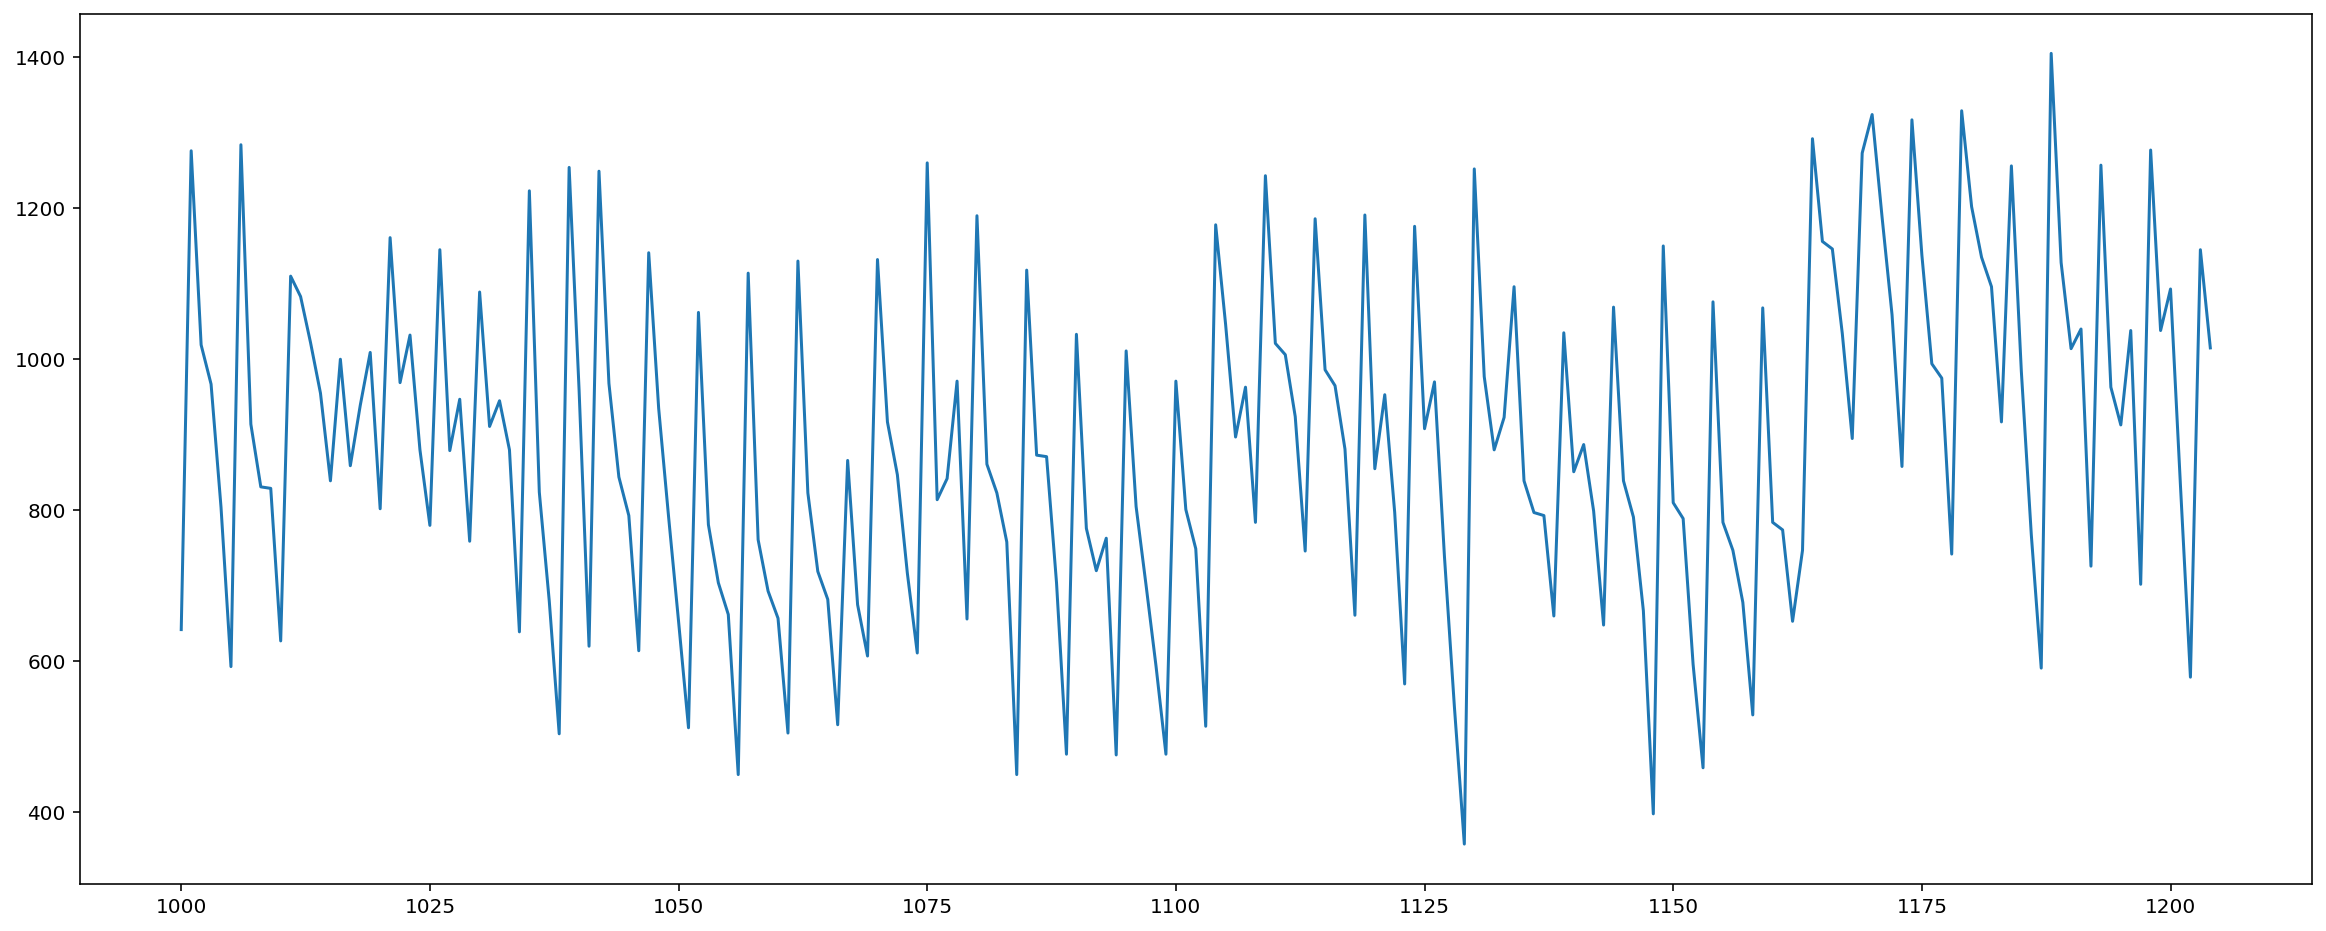

In [56]:
plt.figure(figsize=(20,8))
train.loc[1000:,'중식계'].plot()

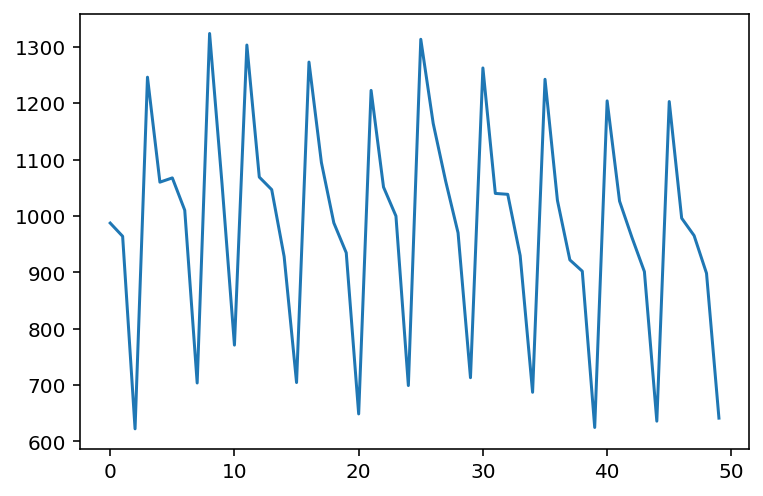

In [57]:
submission_esb['중식계'].plot()

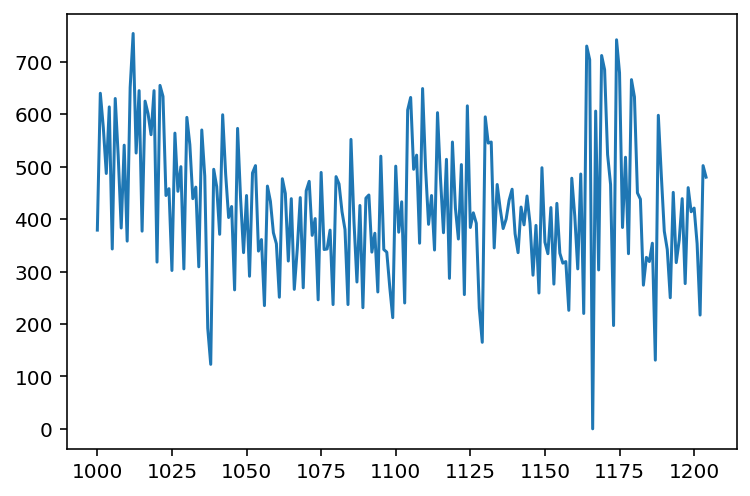

In [58]:
train.loc[1000:,'석식계'].plot()

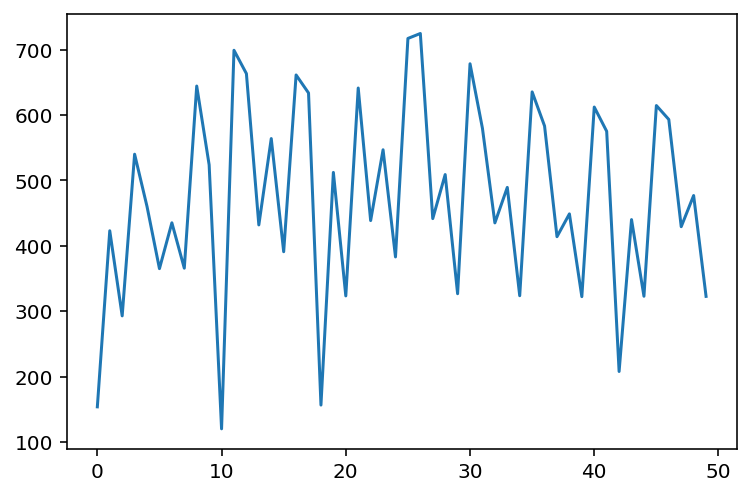

In [40]:
submission_esb['석식계'].plot()